https://stackoverflow.com/questions/73095228/xarray-cannot-open-url

# This is a test of 'zarr_test.ipynb' on https://us-central1-b.gcp.pangeo.io/user/tinaok/lab/, which we-redoing it on eosc.


testing if once .persist, if we loose the data.  
on pangeo us google cloud, we didn't looseit,
but we didn't re-chunk it neither.  

without re-chunking it persist, load from zarr file, all worked ok on eosc too!!

just when activating chunk , we got NaN in plots.



In [1]:
pip install esgf-pyclient

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import kerchunk.hdf
import fsspec
import json
import xarray as xr

In [2]:
from dask_gateway import Gateway
gateway = Gateway()


In [4]:
from dask.distributed import Client
clusters=gateway.list_clusters()
print(clusters )
for cluster in clusters :
    cluster= gateway.connect(cluster.name)
    print(cluster)
    client = Client(cluster)
    client.close()
    cluster.shutdown()

[]


In [5]:
cluster = gateway.new_cluster(worker_memory=8, worker_cores=2)

#cluster.adapt(minimum=4,maximum=40)
cluster


In [6]:
#cluster.adapt(minimum=4,maximum=40)
cluster.scale(20)

In [7]:
from distributed import Client


client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.cd713947bd6a4d10890a3c3a56344daa/status,


## Create kerchunk using pyesgf

In [1]:
from pyesgf.search import SearchConnection
import xarray as xr


In [7]:
server={
    'de':'https://esgf-data.dkrz.de/esg-search',
    'llnl':'http://esgf-node.llnl.gov/esg-search',
    'fr':'https://esgf-data.ipsl.upmc.fr/esg-search',
    'uk':'https://esgf.ceda.ac.uk/esg-search'}

server=server['llnl']
models=['CMCC-CM2-SR5']
variables=['thetao','so']


def create_urls(server,model,variable_id):
    conn = SearchConnection(server, distrib=False)
    activity_id='OMIP'
    experiment_id='omip2'
    project='CMIP6'
    from_timestamp = "1958-01-01T00:00:00Z"
    to_timestamp= "2022-01-01T00:00:00Z"
    #variant_label='r1i1p1f2',
    #data_node='esgf-data3.ceda.ac.uk'
    facets='project,source_id,variable,experiment_id,frequency,from_timestamp,to_timestamp'
    print(server,model,variable_id,'start new_context')
    ctx = conn.new_context(
        facets=facets,
        project=project,
        source_id=model,
        experiment_id=experiment_id,
        variable=variable_id,
    #    from_timestamp=year,
        frequency='mon',
    #    variant_label='r1i1p1f2',
    #    data_node='esgf-data3.ceda.ac.uk'
        from_timestamp = from_timestamp,
        to_timestamp= to_timestamp  
    )
    result = ctx.search()[0]
    #result.dataset_id
    files = result.file_context().search()

    #opendap=[f.opendap_url for f in files]
    download_urls=[f.download_url for f in files]
    
    
    return download_urls

### Here, for some use case, you might not need to transform all the netcdf to kerchunk.  (because the files are divided in 'time' so we should find a way to take out netcdf file which is not in the range of year we want

In [4]:
# a example of simple transformation using pangeo US cloud
model=models[0]
variables=['thetao']
var_urls={var: create_urls(server,model,var) for var in variables}
url=var_urls['thetao'][-1]

url

'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/thetao/gn/v20200226/thetao_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc'

## Use kerchunk to load and test

### at pangeo us google cloud


In [10]:
f='gcs://pangeo-integration-te-3eea-prod-scratch-bucket/tinaok/kerchunk/CMCC-CM2-SR5thetao_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.json'

In [11]:
import gcsfs
fs = gcsfs.GCSFileSystem()
name=os.environ['SCRATCH_BUCKET_NAME']+'/tinaok/' 

fs.ls(name)
#os.environ['SCRATCH_BUCKET_NAME']+ path

['pangeo-integration-te-3eea-prod-scratch-bucket/tinaok/kerchunk']

In [12]:
%%time
ds_t_k=xr.open_dataset(
                        "reference://", engine="zarr",
                        backend_kwargs={
                            "storage_options": {
                                "fo":f,
                                #"target_options":target_options
                            },
                            "consolidated": False
                        } ,chunks={}                    
                    )

CPU times: user 546 ms, sys: 38 ms, total: 584 ms
Wall time: 1.39 s


### at pangeo-eosc

In [8]:
# set storage target
access_key = !aws configure get aws_access_key_id
access_key = access_key[0]
secret_key = !aws configure get aws_secret_access_key
secret_key = secret_key[0]


client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}
target_options={
            "anon":False,
            "client_kwargs":client_kwargs,
            "key":access_key, 
            "secret":secret_key}

In [9]:
f='s3://WAFFLES/kerchunk/CMCC-CM2-SR5/thetao_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.json'


ds_t_k_eosc=xr.open_dataset(
                        "reference://", engine="zarr",
                        backend_kwargs={
                            "storage_options": {
                                "fo":f,
                                "target_options":target_options
                            },
                            "consolidated": False
                        } ,chunks={}                    
                    )

In [10]:
ds_t_k_eosc

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, lev: 50, bnds: 2, time: 732,
                         vertices: 4)
Coordinates:
  * i                   (i) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * j                   (j) float64 0.0 1.0 2.0 3.0 ... 287.0 288.0 289.0 290.0
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev                 (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:0...
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    thetao              (time, lev, j, i) float32 dask.array<chunksize=(1, 25, 146, 180), meta=np.ndarray>
    time_bnds           (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 2), meta=np.ndarray>
Attributes: (12/39)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           OMIP
    cmor_version:          3.5.0
    comment:               Ocean initial conditions: WOA 2013 T & S; ocean at...
    contact:               Pier Giuseppe Fogli (piergiuseppe.fogli@cmcc.it)
    creation_date:         2020-02-19T13:19:38Z
    ...                    ...
    table_id:              Omon
    table_info:            Creation Date:(15 January 2020) MD5:bc48740ff90dcf...
    title:                 CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:           hdl:21.14100/1b7c2d37-0a5c-43c0-8a3b-d534e03c401f
    variable_id:           thetao
    variant_label:         r1i1p1f1

In [11]:
%%time
#chunks={'time':120,'lev':-1,'vertices': -1 }#,'bnds':-1}
ds=ds_t_k_eosc.copy()
#for var in ds:
#    del ds[var].encoding['chunks']

ds=(#ds_t_k
    ds
#    .drop_vars(['lev_bounds','time_bounds','lon_bounds','lat_bounds','bnds'], errors="ignore")
#    .sel(time =slice('1960-01-01',None))
    .sel(time =slice('2000-01-01','2001-01-01'))
#    .assign_coords(
#            latitude= lambda ds : ds.latitude.compute(),
#            longitude= lambda ds : ds.longitude.compute())
#    .where(lambda ds: ds['latitude']>=50 ,drop=True)
#    .chunk(chunks).unify_chunks()
   )
ds#=ds[['thetao']]

CPU times: user 6.71 ms, sys: 4.9 ms, total: 11.6 ms
Wall time: 10.6 ms


<xarray.Dataset>
Dimensions:             (i: 360, j: 291, lev: 50, bnds: 2, time: 12, vertices: 4)
Coordinates:
  * i                   (i) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * j                   (j) float64 0.0 1.0 2.0 3.0 ... 287.0 288.0 289.0 290.0
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev                 (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 2000-01-16 12:00:00 ... 2000-12-16 12:0...
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    thetao              (time, lev, j, i) float32 dask.array<chunksize=(1, 25, 146, 180), meta=np.ndarray>
    time_bnds           (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 2), meta=np.ndarray>
Attributes: (12/39)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           OMIP
    cmor_version:          3.5.0
    comment:               Ocean initial conditions: WOA 2013 T & S; ocean at...
    contact:               Pier Giuseppe Fogli (piergiuseppe.fogli@cmcc.it)
    creation_date:         2020-02-19T13:19:38Z
    ...                    ...
    table_id:              Omon
    table_info:            Creation Date:(15 January 2020) MD5:bc48740ff90dcf...
    title:                 CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:           hdl:21.14100/1b7c2d37-0a5c-43c0-8a3b-d534e03c401f
    variable_id:           thetao
    variant_label:         r1i1p1f1

CPU times: user 1.03 s, sys: 82.6 ms, total: 1.11 s
Wall time: 11 s


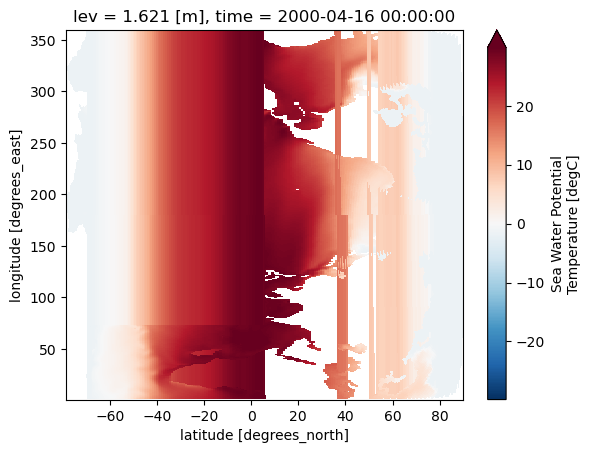

In [12]:
%%time
ds.thetao.sel(
    time='2000-04').isel(
    lev=1).plot(
    x='latitude',y='longitude',robust=True)

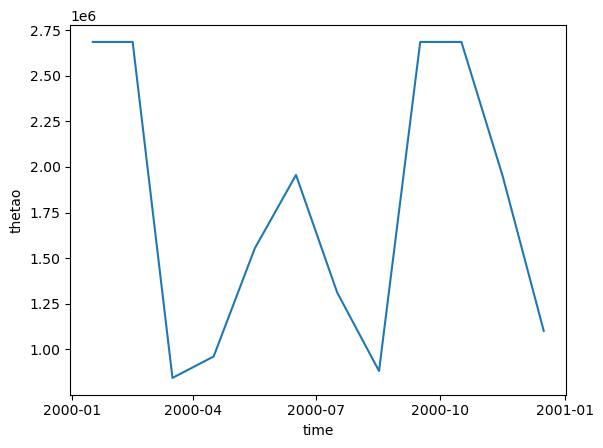

In [13]:
ds.thetao.count(dim=['lev','j','i']).plot()

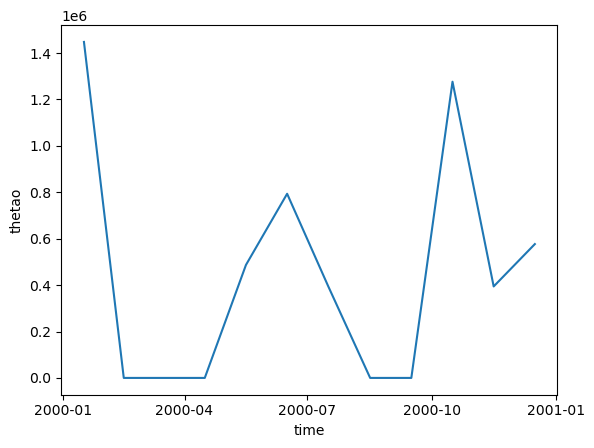

In [14]:
ds.thetao.count(dim=['lev','j','i']).plot()

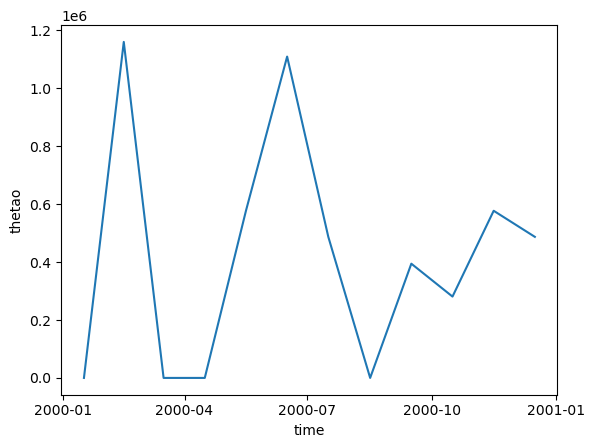

In [15]:
ds.thetao.count(dim=['lev','j','i']).plot()

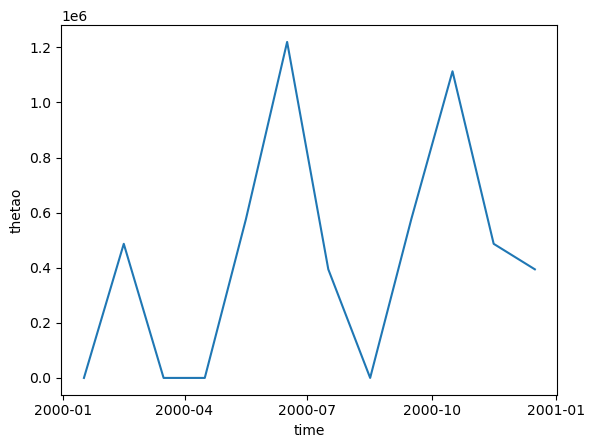

In [16]:
ds.thetao.count(dim=['lev','j','i']).plot()

In [17]:
%%time
ds=ds.persist()

CPU times: user 950 ms, sys: 0 ns, total: 950 ms
Wall time: 946 ms


CPU times: user 384 ms, sys: 51.1 ms, total: 435 ms
Wall time: 7.22 s


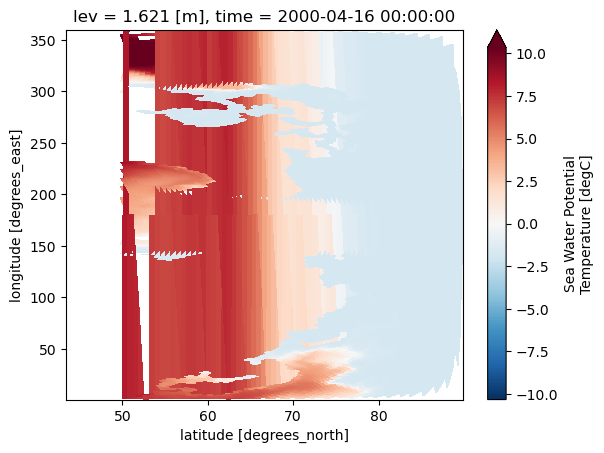

In [13]:
%%time
ds.thetao.sel(time='2000-04').isel(lev=1).plot(x='latitude',y='longitude',robust=True)

In [17]:
import zarr
uri='s3://WAFFLES/tinatest/CMCC-CM2-SR5_t_from_gcs.zarr'
#uri='s3://WAFFLES/tinatest/CMCC-CM2-SR5_t_from_eosc.zarr'
uri='s3://WAFFLES/tinatest/CMCC-CM2-SR5_no_rechunk.zarr'
store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                             key=access_key, secret=secret_key)

In [18]:
%%time 
ds.to_zarr(store=store,mode='w',consolidated=True)

CPU times: user 6.72 s, sys: 928 ms, total: 7.64 s
Wall time: 4min 40s


In [19]:
%%time
loadds=xr.open_zarr(store=store)

CPU times: user 1.76 s, sys: 99.2 ms, total: 1.85 s
Wall time: 36.5 s


In [20]:
loadds

<xarray.Dataset>
Dimensions:    (i: 360, j: 72, lev: 50, time: 708)
Coordinates:
  * i          (i) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * j          (j) float64 219.0 220.0 221.0 222.0 ... 287.0 288.0 289.0 290.0
    latitude   (j, i) float64 dask.array<chunksize=(72, 360), meta=np.ndarray>
  * lev        (lev) float64 0.5126 1.621 2.858 ... 5.1e+03 5.498e+03 5.904e+03
    longitude  (j, i) float64 dask.array<chunksize=(72, 360), meta=np.ndarray>
  * time       (time) object 1960-01-16 12:00:00 ... 2018-12-16 12:00:00
Data variables:
    thetao     (time, lev, j, i) float32 dask.array<chunksize=(1, 25, 72, 180), meta=np.ndarray>
Attributes: (12/39)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           OMIP
    cmor_version:          3.5.0
    comment:               Ocean initial conditions: WOA 2013 T & S; ocean at...
    contact:               Pier Giuseppe Fogli (piergiuseppe.fogli@cmcc.it)
    creation_date:         2020-02-19T13:19:38Z
    ...                    ...
    table_id:              Omon
    table_info:            Creation Date:(15 January 2020) MD5:bc48740ff90dcf...
    title:                 CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:           hdl:21.14100/1b7c2d37-0a5c-43c0-8a3b-d534e03c401f
    variable_id:           thetao
    variant_label:         r1i1p1f1

CPU times: user 102 ms, sys: 7.37 ms, total: 109 ms
Wall time: 588 ms


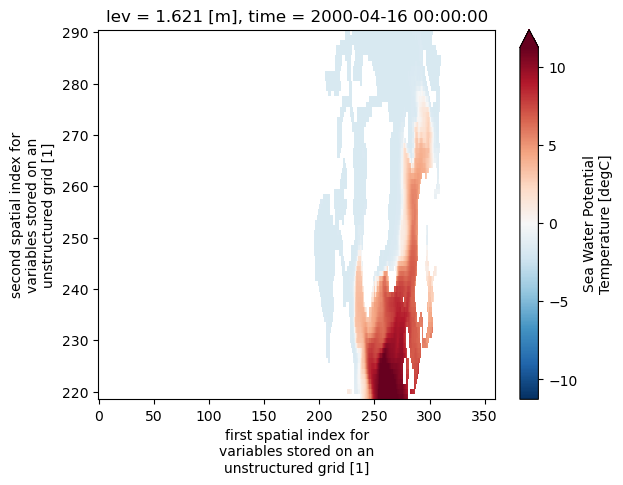

In [21]:
%%time
loadds.thetao.sel(
    time='2000-04').isel(
    lev=1).plot(
    x='i',y='j',robust=True)

In [38]:
loadds.thetao.count(dim=['lev','j','i']).compute()

<xarray.DataArray 'thetao' (time: 708)>
array([     0,      0,      0,      0,      0,      0,      0,      0,
       105660,      0,      0,      0,      0,      0,  87097, 143525,
            0, 143525, 117822,      0,      0, 124962,      0,      0,
        30725, 105660,      0,      0,      0,      0,      0,      0,
            0,  37865,      0,      0,      0,      0,      0,      0,
            0,      0, 105660,      0,  87097,      0, 230622,      0,
            0,      0,  87097,      0,  37865,      0,      0,  30725,
            0,      0,      0,      0,  37865,      0,      0,      0,
            0,      0,      0,      0, 136385,      0,  87097,      0,
            0,      0,      0,  37865,  87097,      0,      0,  87097,
        87097,      0,      0,      0,  87097,      0,      0,  37865,
            0,      0,      0,      0,  37865,      0,  37865,  87097,
            0,      0,      0,      0,  37865,  87097,      0,      0,
        87097,      0,  37865,  37865,      0,  87097,      0,      0,
        87097,      0,      0,      0,  87097,      0,      0,  30725,
        87097,  87097,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,  37865,      0,  87097,      0,      0,
        87097,  30725,      0,  87097,  87097,      0, 124962,      0,
            0,      0,  37865,  37865,      0, 124962,  37865,      0,
...
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,  37865,  87097,      0,      0,  37865,
            0,      0,      0,  87097,  30725,  87097,  37865,      0,
        87097, 124962, 105660,  87097,      0,  87097,      0,      0,
            0,      0,      0,      0,      0,      0, 117822,      0,
            0,      0,  87097,  87097,      0, 143525,      0,      0,
            0,      0,      0,  37865,      0,  87097,      0,      0,
            0,      0,      0,      0,      0,      0, 105660,  87097,
            0,      0,      0,      0,      0,      0,      0,      0,
        30725,      0,  37865,  37865,  30725,  37865,      0,      0,
        87097,  87097,      0,      0,      0,      0,      0, 124962,
       124962,      0,  87097,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
        87097,      0,      0,      0,  87097,      0,  87097,      0,
        30725,      0,  87097,      0, 105660,      0, 136385,      0,
        37865,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,  37865,      0,      0,      0,
        87097,      0,  30725,      0,      0,      0,  87097,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0])
Coordinates:
  * time     (time) object 1960-01-16 12:00:00 ... 2018-12-16 12:00:00

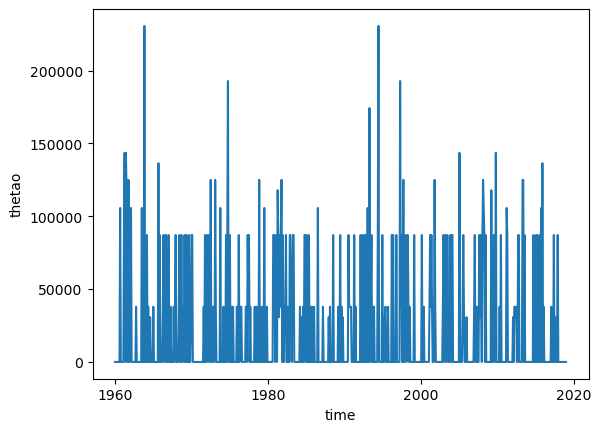

In [39]:
tmp2=_
tmp2.plot()

In [29]:
tmp=_

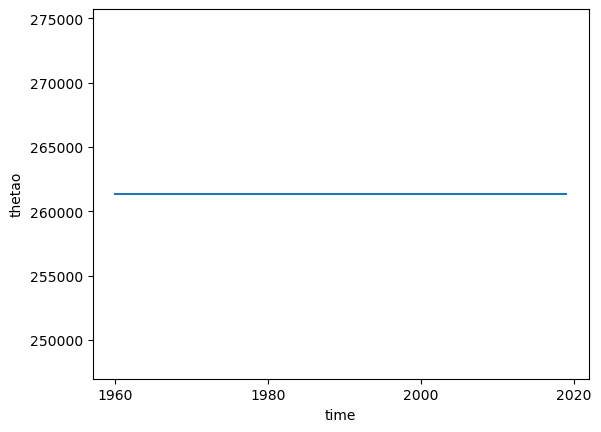

In [30]:
tmp.plot()

In [ ]:
import dask
@dask.delayed
def path_to_kerchunk_eosc(httppath,modelname,client_kwargs,access_key,secret_key):
    import kerchunk.hdf
    import fsspec
    import json
    with fsspec.open(httppath) as inf:
        info = kerchunk.hdf.SingleHdf5ToZarr(inf, httppath, inline_threshold=100).translate()
    jsonname=httppath.rsplit('/')[-1].rsplit('.nc')[0]+'.json'
    path='WAFFLES/kerchunk/'+modelname
#    path='tmp/kerchunk/'+modelname
    s3_prefix = "s3://" + path
    jsonfile = f"{s3_prefix}/{jsonname}"
    print(jsonfile)
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs,key=access_key,secret=secret_key)
    with target.open(jsonfile, mode='w') as f:
        json.dump(info,f)
    return jsonfile


@dask.delayed
def path_to_kerchunk_gcs(httppath,modelname,client_kwargs,access_key,secret_key):
    import kerchunk.hdf
    import fsspec
    import json
    with fsspec.open(httppath) as inf:
        info = kerchunk.hdf.SingleHdf5ToZarr(inf, httppath, inline_threshold=100).translate()
    jsonname=httppath.rsplit('/')[-1].rsplit('.nc')[0]+'.json'
    path='/kerchunk/'+model + '/'
    jsonfile = os.environ['SCRATCH_BUCKET'] + path +jsonname

    with fsspec.open(jsonfile, mode='w') as f:
        json.dump(info,f)
        
    return jsonfile



In [20]:
ds = xr.open_mfdataset(
    opendap, 
    chunks={'time': 120},
    combine='nested',
    concat_dim='time')
ds=ds.sel(
    time=slice('1960',None)
    ).where(lambda ds: ds['latitude']>=50 ,drop=True)



In [65]:
ds

<xarray.Dataset>
Dimensions:             (time: 708, bnds: 2, j: 72, i: 360, lev: 50, vertices: 4)
Coordinates:
  * time                (time) object 1960-01-16 12:00:00 ... 2018-12-16 12:0...
  * lev                 (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
  * j                   (j) int32 219 220 221 222 223 ... 286 287 288 289 290
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float64 dask.array<chunksize=(72, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(72, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds, j, i) object dask.array<chunksize=(96, 2, 72, 360), meta=np.ndarray>
    lev_bnds            (time, lev, bnds, j, i) float64 dask.array<chunksize=(708, 50, 2, 72, 360), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float64 dask.array<chunksize=(708, 72, 360, 4), meta=np.ndarray>
    vertices_longitude  (time, j, i, vertices) float64 dask.array<chunksize=(708, 72, 360, 4), meta=np.ndarray>
    thetao              (time, lev, j, i) float32 dask.array<chunksize=(96, 50, 72, 360), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    comment:                         Ocean initial conditions: WOA 2013 T & S...
    contact:                         Pier Giuseppe Fogli (piergiuseppe.fogli@...
    creation_date:                   2020-02-19T13:20:14Z
    data_specs_version:              01.00.31
    ...                              ...
    variable_id:                     thetao
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by CMCC is lic...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/9f62c488-0e49-4db8-afa5-753...
    DODS_EXTRA.Unlimited_Dimension:  time